In [143]:
import torchdyn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdyn.numerics import AsynchronousLeapfrog
from torchdyn.numerics import odeint, odeint_symplectic

import torchdiffeq
import time 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
vf = nn.Sequential(nn.Linear(2, 32), nn.Tanh(), nn.Linear(32, 2))
class TestSystem(nn.Module):
    def __init__(self, vf):
        super().__init__()
        self.nfe = 0
        self.vf = vf
        self.order = 1

    def forward(self, t, x):
        self.nfe += 1
        return self.vf(x)

In [194]:
f = TestSystem(vf)
x = torch.randn(1024, 2)
t_span = torch.linspace(0, 4, 200)

#### Fixed--step bench

In [195]:
t0 = time.time()
v = f(0., x)
xv = torch.cat([x, v], -1)
solver = AsynchronousLeapfrog(stepping_class='fixed')
t_eval, sol1 = odeint_symplectic(f, xv, t_span, solver=solver)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol2 = torchdiffeq.odeint(f, x, t_span, method='midpoint')
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.1455554962158203
0.12147045135498047


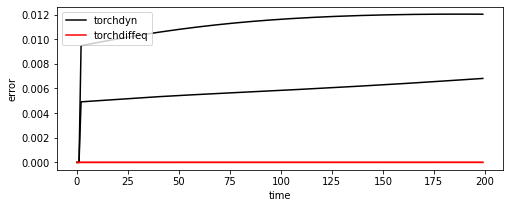

In [196]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
line, _ = ax.plot((sol1[...,:2]-true_sol).detach().abs().mean(1), c='black')
line.set_label('torchdyn')
line, _ = ax.plot((sol2-true_sol).detach().abs().mean(1), c='red')
line.set_label('torchdiffeq')
ax.set_ylabel('error')
ax.set_xlabel('time')
plt.legend()